<a href="https://colab.research.google.com/github/sahil301290/CRBP-3D-to-2.5D/blob/main/01_CRBP_EDA_and_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CRBP: A Benchmark Dataset of Color-Rendered 3D-to-2.5D Facial Projections

####Fetching Data: Bosphorus Original, CRBP-Raw, and CRBP-YOLOv8

In [1]:
!gdown 1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4 -O CRBP-Yolov8.zip
!gdown 1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6 -O CRBP-Raw.zip
!unzip -q "/content/CRBP-Yolov8.zip"
!rm -rf "/content/CRBP-Yolov8.zip"
!unzip -q "/content/CRBP-Raw.zip"
!rm -rf "/content/CRBP-Raw.zip"
!apt-get install -y p7zip-full
!7z x "/content/drive/MyDrive/Datasets/3D Face/Bosphorus_Unzipped.zip" -o"/content/Bosphorus" -mmt

Downloading...
From (original): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4
From (redirected): https://drive.google.com/uc?id=1EgVcuzX2IghjBYFnPaGMEwFYNpo4QJI4&confirm=t&uuid=73b7dc53-a6b8-4c62-ab22-58c7c533b704
To: /content/CRBP-Yolov8.zip
100% 1.04G/1.04G [00:15<00:00, 66.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6
From (redirected): https://drive.google.com/uc?id=1X0Nz1x2r31scd3cTTRwJ9LnCZYRuSdn6&confirm=t&uuid=f50788ce-91fc-4f7a-a154-1eb09d46a53a
To: /content/CRBP-Raw.zip
100% 2.39G/2.39G [00:29<00:00, 81.9MB/s]
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (4

####Comparative Analysis

In [2]:
import os
import json
import pandas as pd
from collections import defaultdict
from IPython.display import display

# === CONFIGURATION ===
raw_base_dir = "/content/CRBP-Raw"
processed_base_dir = "/content/CRBP-Yolov8"
bosphorus_json_path = "/content/drive/MyDrive/Datasets/3D Face/bosphorus_metadata_full.json"
output_dir = "/content/CRBP-Statistics"
os.makedirs(output_dir, exist_ok=True)

# === FUNCTION: Regex-based Category/Subcategory parser ===
def parse_base_name(base_name):
    name = base_name.lower()

    # Emotion
    if '_e_' in name:
        return 'Emotion', name.split('_e_')[1].split('_')[0].title()

    # Occlusion subtypes like _O_HAIR_, _O_EYE_, etc.
    elif '_o_' in name:
        parts = name.split('_o_')[1].split('_')
        subtype_raw = parts[0].lower() if parts else 'unknown'
        subtype_map = {
            'eye': 'Eye',
            'hair': 'Hair',
            'mouth': 'Mouth',
            'glasses': 'Glasses'
        }
        subtype = subtype_map.get(subtype_raw, subtype_raw.capitalize())
        return 'Occlusion', f'{subtype}'

    # Pose
    elif '_yr_' in name:
        return 'Pose', 'Yaw Rotation'
    elif '_pr_' in name:
        return 'Pose', 'Pitch Rotation'
    elif '_cr_' in name:
        return 'Pose', 'Cross Rotation'

    # Neutral
    elif '_n_' in name:
        return 'Neutral', 'Neutral'

    # Action Units
    elif 'ufau' in name:
        return 'Action Unit', 'Upper Face AU'
    elif 'lfau' in name:
        return 'Action Unit', 'Lower Face AU'
    elif '_cau_' in name:
        return 'Action Unit', 'Combined AU'

    else:
        return None, None  # Skip unknown or IGN_INV files

# === STEP 1: Parse Bosphorus JSON metadata ===
original_counter = defaultdict(lambda: defaultdict(int))
bosphorus_base_names = []

with open(bosphorus_json_path, "r") as f:
    metadata = json.load(f)
    for entry in metadata:
        base_name = entry["base_name"].lower()
        if "ign_inv" in base_name:
            continue  # Skip IGN_INV
        cat, subcat = parse_base_name(base_name)
        if cat and subcat:
            original_counter[cat][subcat] += 1
            bosphorus_base_names.append(base_name)

df_original = pd.DataFrame([
    {"Category": cat, "Subcategory": sub, "Original": count}
    for cat, subcounts in original_counter.items()
    for sub, count in subcounts.items()
])

# === STEP 2: Parse CRBP datasets (raw and YOLO) ===
def parse_crbp_dataset(base_dir, label):
    counter = defaultdict(lambda: defaultdict(int))
    skipped_files = 0

    for subject in os.listdir(base_dir):
        subdir = os.path.join(base_dir, subject)
        if not os.path.isdir(subdir): continue

        for file in os.listdir(subdir):
            filename = file.lower()
            if not filename.endswith(('.png', '.jpg', '.jpeg')):
                continue
            if 'ign_inv' in filename:
                skipped_files += 1
                continue

            base_name = os.path.splitext(filename)[0]
            cat, subcat = parse_base_name(base_name)
            if cat and subcat:
                counter[cat][subcat] += 1

    df = pd.DataFrame([
        {"Category": cat, "Subcategory": sub, label: count}
        for cat, subcounts in counter.items()
        for sub, count in subcounts.items()
    ])

    print(f"🔍 Skipped {skipped_files} IGN_INV files from: {base_dir}")
    return df

df_crbp_raw = parse_crbp_dataset(raw_base_dir, "CRBP_Raw")
df_crbp_yolo = parse_crbp_dataset(processed_base_dir, "CRBP_YOLOv8")

# === STEP 3: Merge all and compute deltas ===
df_compare = df_original.merge(df_crbp_raw, on=["Category", "Subcategory"], how="outer") \
                        .merge(df_crbp_yolo, on=["Category", "Subcategory"], how="outer") \
                        .fillna(0)

for col in ["Original", "CRBP_Raw", "CRBP_YOLOv8"]:
    df_compare[col] = df_compare[col].astype(int)

df_compare["CRBP_Raw_Δ%"] = (
    (df_compare["CRBP_Raw"] - df_compare["Original"]) / df_compare["Original"].replace(0, 1)
) * 100

df_compare["CRBP_YOLOv8_Δ%"] = (
    (df_compare["CRBP_YOLOv8"] - df_compare["Original"]) / df_compare["Original"].replace(0, 1)
) * 100

# === Clean output ===
df_compare = df_compare[df_compare["Category"].notnull()]

# === STEP 4: Save and show ===
output_path = os.path.join(output_dir, "comparison_original_crbp.csv")
df_compare.to_csv(output_path, index=False)

# print("✅ Comparison table saved at:", output_path)
# display(df_compare.sort_values("Original", ascending=False).reset_index(drop=True))
# Display table
print("✅ Comparison table saved at:", output_path)
df_display = df_compare.sort_values("Original", ascending=False).reset_index(drop=True)
display(df_display)

# Compute and print total
total_original_images = df_compare["Original"].sum()
print(f"\n🧮 Total images in Original Bosphorus Dataset (excluding IGN_INV): {total_original_images}")

🔍 Skipped 108 IGN_INV files from: /content/CRBP-Raw
🔍 Skipped 67 IGN_INV files from: /content/CRBP-Yolov8
✅ Comparison table saved at: /content/CRBP-Statistics/comparison_original_crbp.csv


,Category,Subcategory,Original,CRBP_Raw,CRBP_YOLOv8,CRBP_Raw_Δ%,CRBP_YOLOv8_Δ%
0,Action Unit,Lower Face AU,1549,9294,5545,500.0,257.972886
1,Pose,Yaw Rotation,735,4410,1826,500.0,148.435374
2,Action Unit,Upper Face AU,432,2592,1511,500.0,249.768519
3,Pose,Pitch Rotation,419,2514,1346,500.0,221.241050
4,Neutral,Neutral,299,1794,1041,500.0,248.160535
5,Pose,Cross Rotation,211,1266,606,500.0,187.203791
6,Action Unit,Combined AU,169,1014,592,500.0,250.295858
7,Emotion,Happy,106,636,372,500.0,250.943396
8,Occlusion,Eye,105,630,341,500.0,224.761905
9,Occlusion,Mouth,105,630,280,500.0,166.666667



🧮 Total images in Original Bosphorus Dataset (excluding IGN_INV): 4648


####Plotting Data Distribution

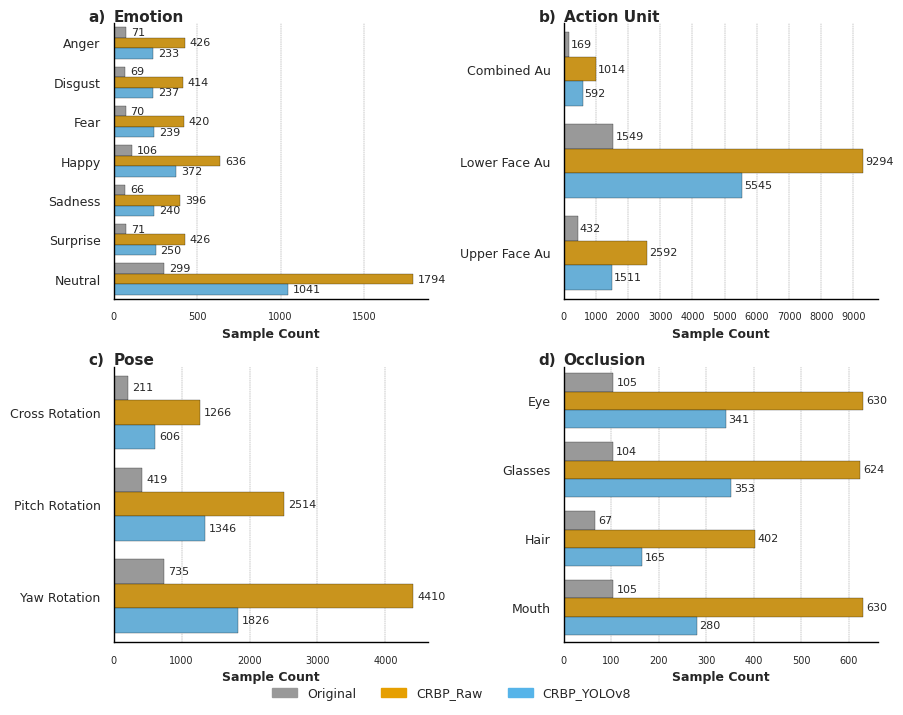

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import string
import matplotlib.patches as mpatches

# === Load and format data ===
csv_path = '/content/CRBP-Statistics/comparison_original_crbp.csv'
df = pd.read_csv(csv_path)
df.loc[df["Category"] == "Neutral", "Category"] = "Emotion"
df['Subcategory'] = df['Subcategory'].str.title()

# === Melt into long format ===
df_melted = df.melt(
    id_vars=['Category', 'Subcategory'],
    value_vars=['Original', 'CRBP_Raw', 'CRBP_YOLOv8'],
    var_name='Dataset',
    value_name='Sample Count'
)

# === Plot styling (IEEE 1-col ready) ===
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 9,
    "axes.labelsize": 9,
    "axes.titlesize": 11,
    "xtick.labelsize": 7,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.titleweight": 'bold',
    "axes.labelweight": 'bold',
    "axes.linewidth": 0.4,
    "pdf.fonttype": 42,
    "axes.unicode_minus": False
})

# === Color-blind safe palette & legend order ===
palette = {
    'Original': '#999999',
    'CRBP_Raw': '#E69F00',
    'CRBP_YOLOv8': '#56B4E9'
}
legend_order = ['Original', 'CRBP_Raw', 'CRBP_YOLOv8']

# === Create the 2×2 FacetGrid (no auto-legend) ===
g = sns.catplot(
    data=df_melted,
    kind="bar",
    x="Sample Count",
    y="Subcategory",
    hue="Dataset",
    col="Category",
    col_order=["Emotion", "Action Unit", "Pose", "Occlusion"],
    col_wrap=2,
    palette=palette,
    sharex=False,
    sharey=False,
    height=3.5,
    aspect=1.3,
    legend=False
)

# === Per-panel settings ===
tick_intervals = [500, 1000, 1000, 100]
categories = ["Emotion", "Action Unit", "Pose", "Occlusion"]

for i, ax in enumerate(g.axes.flat):
    ax.set_title("")
    ax.set_ylabel("")
    ax.set_xlabel("Sample Count")

    # Custom x-axis tick intervals
    interval = tick_intervals[i]
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))
    ax.grid(True, axis='x', linestyle='--', linewidth=0.3, color='gray')

    # Strong visible x and y axis spines
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['left'].set_color('black')

    # Hide top/right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Subplot letter label (a), b), etc.)
    ax.text(-0.08, 1.05, f"{string.ascii_lowercase[i]})",
            transform=ax.transAxes, fontsize=11, fontweight='bold', va='top', ha='left')

    # Panel title (left-aligned)
    ax.text(0, 1.05, categories[i],
            transform=ax.transAxes, fontsize=11, fontweight='bold', ha='left', va='top')

    # Annotate bars + optional bar edge
    for bar in ax.patches:
        width = bar.get_width()
        if width > 0:
            bar.set_edgecolor('black')
            bar.set_linewidth(0.2)
            ax.text(
                width + interval * 0.06,
                bar.get_y() + bar.get_height() / 2,
                f"{int(width)}",
                va='center',
                ha='left',
                fontsize=8
            )

# === Manual bottom-centered legend ===
handles = [mpatches.Patch(color=palette[name], label=name) for name in legend_order]
g.fig.legend(
    handles, legend_order,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=3,
    frameon=False
)

# === Final layout adjustments and export ===
plt.subplots_adjust(hspace=0.45, wspace=0.35)
plt.tight_layout()
g.savefig("/content/CRBP_sample_distribution_facet.png", dpi=600, bbox_inches='tight')
g.savefig("/content/CRBP_sample_distribution_facet.pdf", dpi=600, bbox_inches='tight')
plt.show()

In [10]:
import os
import json

# === Directories ===
bosphorus_dir = '/content/Bosphorus/Bosphorus_Preprocessed'
crbp_raw_dir = '/content/CRBP-Raw'
crbp_yolo_dir = '/content/CRBP-Yolov8'
output_json = '/content/CRBP-Statistics/triplet_metadata.json'
os.makedirs(os.path.dirname(output_json), exist_ok=True)

# === Your parsing function ===
def parse_base_name(base_name):
    name = base_name.lower()

    if '_e_' in name:
        return 'Emotion', name.split('_e_')[1].split('_')[0].title()
    elif '_o_' in name:
        parts = name.split('_o_')[1].split('_')
        subtype_raw = parts[0].lower() if parts else 'unknown'
        subtype_map = {
            'eye': 'Eye',
            'hair': 'Hair',
            'mouth': 'Mouth',
            'glasses': 'Glasses'
        }
        subtype = subtype_map.get(subtype_raw, subtype_raw.capitalize())
        return 'Occlusion', subtype
    elif '_yr_' in name:
        return 'Pose', 'Yaw Rotation'
    elif '_pr_' in name:
        return 'Pose', 'Pitch Rotation'
    elif '_cr_' in name:
        return 'Pose', 'Cross Rotation'
    elif '_n_' in name:
        return 'Emotion', 'Neutral'
    elif 'ufau' in name:
        return 'Action Unit', 'Upper Face AU'
    elif 'lfau' in name:
        return 'Action Unit', 'Lower Face AU'
    elif '_cau_' in name:
        return 'Action Unit', 'Combined AU'
    else:
        return None, None

# === Build triplets ===
triplets = []
skipped = []
total_yolo_images = 0

for root, _, files in os.walk(crbp_yolo_dir):
    for fname in files:
        if not fname.lower().endswith('.png'):
            continue
        total_yolo_images += 1

        subject_id = os.path.basename(root)
        base_name = os.path.splitext(fname)[0]
        category, subcategory = parse_base_name(base_name)

        if not category or not subcategory:
            skipped.append((fname, "Unrecognized pattern"))
            continue

        yolo_path = os.path.join(root, fname)
        raw_path = os.path.join(crbp_raw_dir, subject_id, fname)

        # Construct bosphorus path: everything up to the second `_0_` becomes `_0.png`
        # if '_0_' in base_name:
        #     bos_base = base_name.split('_0_')[0] + '_0.png'
        # else:
        #     skipped.append((fname, "Missing '_0_' for Bosphorus base"))
        #     continue

        # Attempt to reconstruct bosphorus base: first 4 components of filename
        parts = base_name.split('_')
        if len(parts) >= 4:
            bos_base = '_'.join(parts[:4]) + '.png'
        else:
            skipped.append((fname, "Cannot extract 4-part bosphorus base"))
            continue


        bosphorus_path = os.path.join(bosphorus_dir, subject_id, bos_base)

        if not os.path.exists(raw_path):
            skipped.append((fname, "Missing CRBP-Raw"))
            continue
        if not os.path.exists(bosphorus_path):
            skipped.append((fname, "Missing Bosphorus"))
            continue

        triplets.append({
            'category': category,
            'subcategory': subcategory,
            'bosphorus_path': bosphorus_path,
            'crbp_raw_path': raw_path,
            'crbp_yolo_path': yolo_path
        })

# === Save JSON ===
with open(output_json, 'w') as f:
    json.dump(triplets, f, indent=2)

# === Print stats ===
print(f"[✓] JSON saved: {output_json}")
print(f"[INFO] Total CRBP-YOLOv8 .png images: {total_yolo_images}")
print(f"[INFO] Valid triplets in JSON: {len(triplets)}")
print(f"[INFO] Skipped entries: {len(skipped)}")

# Optional: Print first few skipped
for fname, reason in skipped[:5]:
    print(f"[SKIPPED] {fname} → {reason}")

[✓] JSON saved: /content/CRBP-Statistics/triplet_metadata.json
[INFO] Total CRBP-YOLOv8 .png images: 15244
[INFO] Valid triplets in JSON: 15177
[INFO] Skipped entries: 67
[SKIPPED] bs092_IGN_INV_0_5.png → Unrecognized pattern
[SKIPPED] bs092_IGN_INV_0_1.png → Unrecognized pattern
[SKIPPED] bs092_IGN_INV_0_6.png → Unrecognized pattern
[SKIPPED] bs092_IGN_INV_0_4.png → Unrecognized pattern
[SKIPPED] bs081_IGN_INV_0_1.png → Unrecognized pattern


In [18]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image

# === Paths ===
json_path = '/content/CRBP-Statistics/triplet_metadata.json'
output_dir = 'figures'
os.makedirs(output_dir, exist_ok=True)

# === Load triplet metadata
with open(json_path, 'r') as f:
    triplets = json.load(f)

# === Group triplets by (category, subcategory)
triplet_map = {}
for entry in triplets:
    key = (entry['category'], entry['subcategory'])
    triplet_map.setdefault(key, []).append(entry)

# === Define the figures ===
figure_specs = {
    'Emotion': {
        'subcategories': ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise', 'Neutral'],
        'filename': 'figure1_emotion'
    },
    'Action Unit': {
        'subcategories': ['Combined AU', 'Lower Face AU', 'Upper Face AU'],
        'filename': 'figure2_action_unit'
    },
    'Pose': {
        'subcategories': ['Yaw Rotation', 'Pitch Rotation', 'Cross Rotation'],
        'filename': 'figure3_pose'
    },
    'Occlusion': {
        'subcategories': ['Eye', 'Glasses', 'Hair', 'Mouth'],
        'filename': 'figure4_occlusion'
    }
}

# === Generate figures ===
for fig_idx, (category, spec) in enumerate(figure_specs.items()):
    subcats = spec['subcategories']
    fig, axes = plt.subplots(len(subcats), 3, figsize=(6.5, 2.2 * len(subcats)), dpi=600)

    for i, subcat in enumerate(subcats):
        candidates = triplet_map.get((category, subcat), [])
        if not candidates:
            print(f"[WARNING] No triplets for {category} > {subcat}")
            continue

        sample = random.choice(candidates)
        try:
            bos_img = Image.open(sample['bosphorus_path']).resize((224, 224))
            raw_img = Image.open(sample['crbp_raw_path']).resize((224, 224))
            yolo_img = Image.open(sample['crbp_yolo_path']).resize((224, 224))
        except Exception as e:
            print(f"[ERROR] Failed to open image for {subcat} → {e}")
            continue

        for j, img in enumerate([bos_img, raw_img, yolo_img]):
            ax = axes[i, j] if len(subcats) > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            # Column titles only for top row
            if i == 0:
                ax.set_title(['Bosphorus Original', 'CRBP-Raw', 'CRBP-YOLOv8'][j], fontsize=10, fontweight='bold')

    # Improved row labels (subcategory names), rotated and better aligned
    row_spacing = 1.0 / len(subcats)
    label_x = 0.02  # fine-tuned horizontal placement
    for i, subcat in enumerate(subcats):
        y_pos = 1.0 - (i + 0.5) * row_spacing
        fig.text(label_x, y_pos, subcat, fontsize=10, fontweight='bold',
                 va='center', ha='center', rotation=90)

    # Adjust layout to minimize white space and align rotated labels tightly
    plt.subplots_adjust(left=0.06, top=0.95, bottom=0.02)

    # Save to PNG and PDF
    png_path = os.path.join(output_dir, f'{spec["filename"]}.png')
    pdf_path = os.path.join(output_dir, f'{spec["filename"]}.pdf')
    fig.savefig(png_path, dpi=600, bbox_inches='tight')
    fig.savefig(pdf_path, dpi=600, bbox_inches='tight')
    plt.close()
    print(f"[SAVED] {png_path}, {pdf_path}")

[SAVED] figures/figure1_emotion.png, figures/figure1_emotion.pdf
[SAVED] figures/figure2_action_unit.png, figures/figure2_action_unit.pdf
[SAVED] figures/figure3_pose.png, figures/figure3_pose.pdf
[SAVED] figures/figure4_occlusion.png, figures/figure4_occlusion.pdf


####Visualizing YOLOv8 Cropped Faces by Subcategory

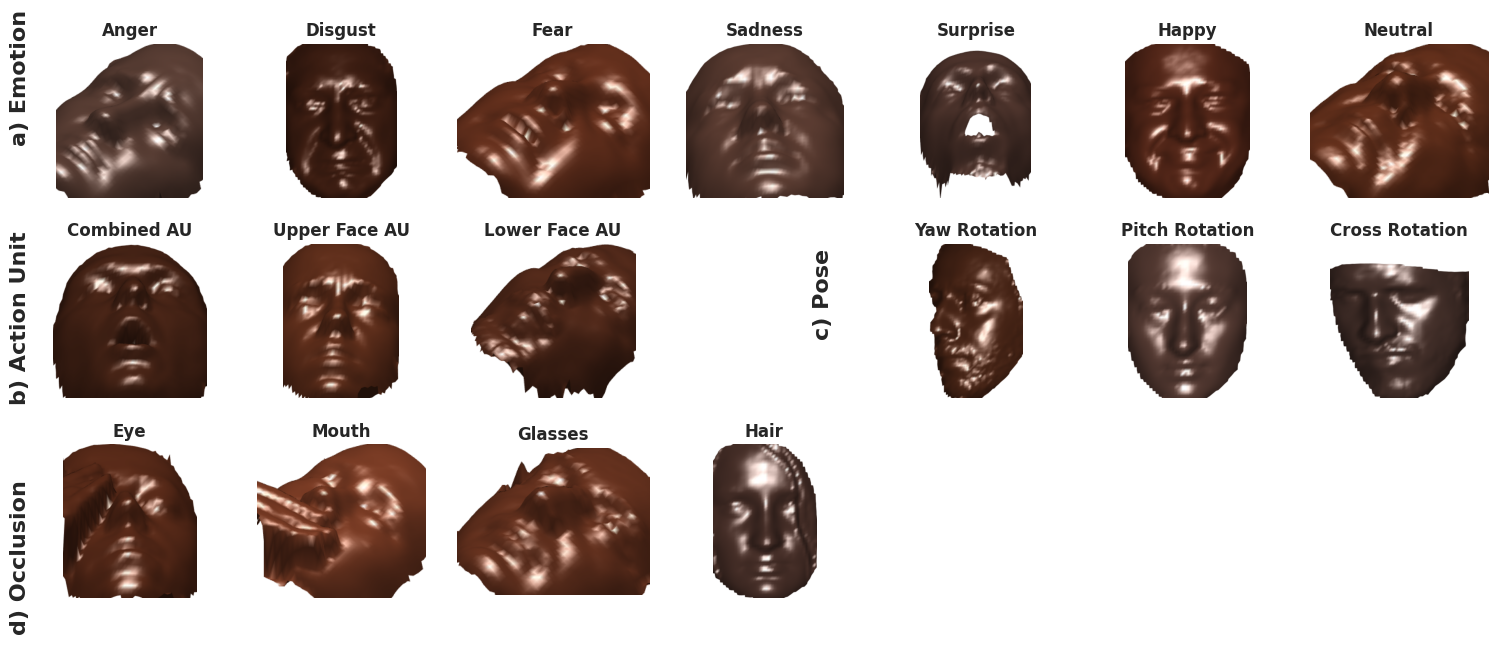

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# === CONFIGURATION ===
image_base = "/content/CRBP-Yolov8"
output_path = "/content/CRBP_faces_by_subcategory.png"
random.seed(12345)

# === FUNCTION: Parse base_name to category/subcategory ===
def parse_base_name(base_name):
    name = base_name.lower()
    if '_e_' in name:
        return 'Emotion', name.split('_e_')[1].split('_')[0].title()
    elif '_o_' in name:
        parts = name.split('_o_')[1].split('_')
        subtype_raw = parts[0].lower() if parts else 'unknown'
        subtype_map = {'eye': 'Eye', 'hair': 'Hair', 'mouth': 'Mouth', 'glasses': 'Glasses'}
        subtype = subtype_map.get(subtype_raw, subtype_raw.capitalize())
        return 'Occlusion', subtype
    elif '_yr_' in name:
        return 'Pose', 'Yaw Rotation'
    elif '_pr_' in name:
        return 'Pose', 'Pitch Rotation'
    elif '_cr_' in name:
        return 'Pose', 'Cross Rotation'
    elif '_n_' in name:
        return 'Emotion', 'Neutral'
    elif 'ufau' in name:
        return 'Action Unit', 'Upper Face AU'
    elif 'lfau' in name:
        return 'Action Unit', 'Lower Face AU'
    elif '_cau_' in name:
        return 'Action Unit', 'Combined AU'
    return None, None

# === Subcategory panel definitions (merged layout) ===
grouped_rows = [
    ("Emotion", ['Anger', 'Disgust', 'Fear', 'Sadness', 'Surprise', 'Happy', 'Neutral']),
    ("Action+Pose", ['Combined AU', 'Upper Face AU', 'Lower Face AU',  # Action Units: col 0–2
                     None,  # empty slot (col 3) for spacing
                     'Yaw Rotation', 'Pitch Rotation', 'Cross Rotation']),  # Pose: col 4–6
    ("Occlusion", ['Eye', 'Mouth', 'Glasses', 'Hair'])
]

# === Image selection ===
subcategory_images = {}
for root, _, files in os.walk(image_base):
    for file in files:
        if not file.lower().endswith('.png') or 'ign_inv' in file.lower():
            continue
        base_name = os.path.splitext(file)[0]
        cat, subcat = parse_base_name(base_name)
        if cat and subcat:
            subcategory_images.setdefault(subcat, []).append(os.path.join(root, file))

# Choose 1 image per subcategory
final_images = {k: random.choice(v) for k, v in subcategory_images.items() if v}

# === Plot setup ===
rows = len(grouped_rows)  # 3 physical rows
cols = max(len(subcats) for _, subcats in grouped_rows)
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2.4, rows * 2.4))
axs = axs if rows > 1 else [axs]  # Ensure 2D list of axes

plt.subplots_adjust(left=0.03, hspace=0.3, wspace=0.1)

# === Plot each subcategory image ===
for row_idx, (cat_title, subcats) in enumerate(grouped_rows):
    for col_idx in range(cols):
        ax = axs[row_idx][col_idx]
        ax.axis('off')
        if col_idx < len(subcats):
            subcat = subcats[col_idx]
            if subcat is not None:
                img_path = final_images.get(subcat)
                if img_path:
                    img = mpimg.imread(img_path)
                    ax.imshow(img)
                    ax.set_title(subcat, fontsize=12, fontweight='bold')


# === Add rotated labels for a), b), d) on y-axis ===
row_spacing = 1.0 / rows
label_x = 0.022  # moved slightly right from 0.012 for better visual centering

# a)
fig.text(label_x, 1.0 - (0 + 0.5) * row_spacing, 'a) Emotion',
         fontsize=16, fontweight='bold', va='center', ha='center', rotation=90)

# b)
row1_y = 1.0 - (1 + 0.5) * row_spacing
fig.text(label_x, row1_y, 'b) Action Unit',
         fontsize=16, fontweight='bold', va='center', ha='center', rotation=90)

# d)
fig.text(label_x, 1.0 - (2 + 0.5) * row_spacing, 'd) Occlusion',
         fontsize=16, fontweight='bold', va='center', ha='center', rotation=90)

# === Add rotated 'c) Pose' under 4th image of row a), moved 1 cm lower ===
col_index = 3
row_index = 0
x_pos = (col_index + 0.5) / cols
y_base = 1.0 - (row_index + 1) / rows - 0.05  # original y_pos

# Compute 1 cm in figure units
fig_height_inch = rows * 2.4  # same as your figsize
cm_in_fig_units = 0.60 / fig_height_inch

y_pos = y_base - cm_in_fig_units  # move label down by 1 cm

fig.text(x_pos, y_pos, 'c) Pose',
         fontsize=16, fontweight='bold',
         va='center', ha='center', rotation=90)

# === Save as PNG ===
plt.savefig(output_path, dpi=600, bbox_inches='tight')

# === Save as PDF ===
pdf_output_path = output_path.replace('.png', '.pdf')
plt.savefig(pdf_output_path, dpi=600, bbox_inches='tight')

# === Show Plot ===
plt.show()